# Moment propagation and first covering attempt

This notebook describes our attempt at using the moment propagation approach assuming that at each layer of the network, all propagated variables are Gaussians. Moreover, we make first experiments with propagating a covering. 

This notebook is also not relevant to our final result, except that it shows how the Gaussianity assumption is unrealistic, however it is included to document our work.

In [2]:
include("../src/DSI.jl")
include("../src/Zono_utils.jl")
include("../src/PZono.jl")
include("../src/DSZ.jl")
include("../src/propagation.jl")

check_property (generic function with 1 method)

In [3]:
using SpecialFunctions

# P-box setup

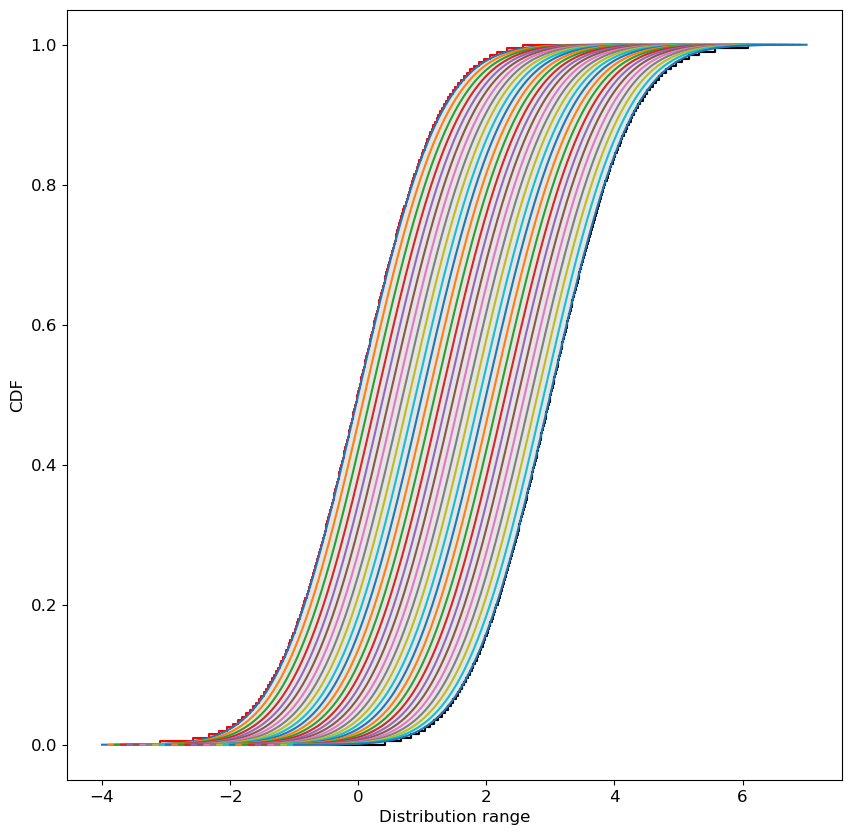

In [4]:
using PyPlot
using Distributions

c = normal(interval(0,3),1)
ProbabilityBoundsAnalysis.plot(c)

arr = []
for mean in 0:0.1:3
    normal_dist = Normal(mean, 1)
    push!(arr, normal_dist)
    x = range(mean - 4, mean + 4, length=1000)
    cdf_values = cdf.(normal_dist, x)
    plot(x, cdf_values)
end

PyPlot.savefig("parametric.png")

In [11]:
W1 = [1 -1.0; 1.0 1.]
b = [0.0; 0.0]
W2 = [1 -1.0; 1.0 1.]
L1 = Layer(W1, b, ReLU())
L2 = Layer(W2, b, Id())
full_net = Network([L1; L2])
# input range
x = [normal(interval(0,1),1), normal(interval(0,1),1)]

2-element Vector{pbox}:
 Pbox: 	  ~ normal ( range=[-3.0902, 4.0902], mean=[0.0, 1.0], var=1.0)
 Pbox: 	  ~ normal ( range=[-3.0902, 4.0902], mean=[0.0, 1.0], var=1.0)

# Moment-propagation approach

Implementation of the moment propagation approach introduced in https://arxiv.org/abs/2403.16163. 

In [12]:
function propagate_network(mean_x, cov_x, network::Network)
    for layer in network.layers
        mean_x, cov_x = propagate_layer(mean_x, cov_x, layer)
    end
    return mean_x, cov_x
end

propagate_network (generic function with 1 method)

In [13]:
function propagate_layer(mean_x, cov_x, layer::Layer)
    mean_y = layer.weights * mean_x .+ layer.bias
    cov_y = layer.weights * cov_x * transpose(layer.weights)
    if layer.activation === ReLU()
        mean_z, cov_z = propagate_relu(mean_y, cov_y)
    elseif layer.activation === Id()
        mean_z, cov_z = mean_y, cov_y
    end
    
    return mean_z, cov_z
end

propagate_layer (generic function with 1 method)

In [14]:
function propagate_relu(mean_y, cov_y)
    var_y = diag(cov_y)
    std_y = sqrt.(var_y)

    std_y = std_y .+ 1e-8

    alpha = mean_y ./ std_y
    CDF_alpha = 0.5 * (1 .+ erf.(alpha ./ sqrt(2))) 
    PDF_alpha = exp.(-0.5 .* alpha.^2) ./ sqrt(2π) 

    mean_z = mean_y .* CDF_alpha .+ std_y .* PDF_alpha

    derelu = []
    push!(derelu,CDF_alpha)
    push!(derelu, PDF_alpha ./ std_y)
    push!(derelu, -mean_y ./ (std_y.^3) .* PDF_alpha)
    push!(derelu, PDF_alpha ./ (std_y.^3) .* ((mean_y.^2 ./ (std_y.^2)) .- 1))
    push!(derelu, - mean_y./ (std_y.^5) .* ((mean_y./std_y).^2 .- 3) .* PDF_alpha)

    n = length(mean_y)
    cov_z = zeros(n, n)
    for i in 1:n
        for j in 1:n
            rho_ij = cov_y[i, j] / (std_y[i] * std_y[j])
            for k in 1:5
                cov_z[i, j] += ((rho_ij^k)/factorial(k)) * (std_y[i]^k * derelu[k][i]) * (std_y[j]^k * derelu[k][j])
            end
        end
    end

    return mean_z, cov_z
end

propagate_relu (generic function with 1 method)

Testing this on the toy example:

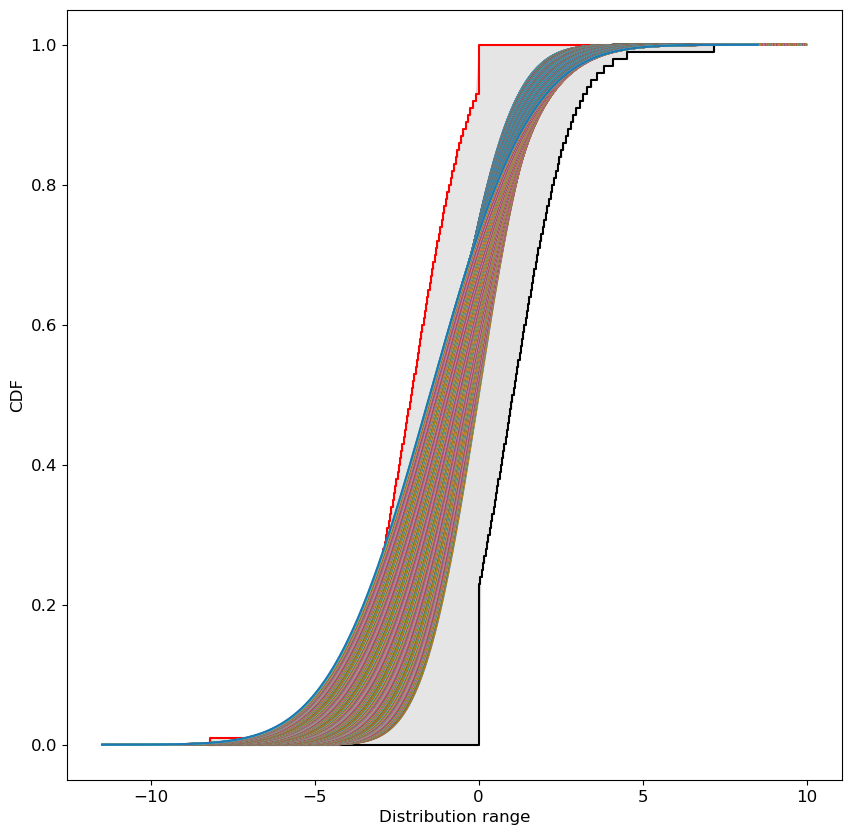

In [17]:
nb_discretization_steps = 100
ProbabilityBoundsAnalysis.setSteps(nb_discretization_steps)
pz = pbox_approximate_nnet(full_net, x, true)
ProbabilityBoundsAnalysis.plot(pz[1])

mean_arr = [0:0.01:1;]

for i in 1:length(mean_arr)
    for j in i:length(mean_arr)
        mean_input = [mean_arr[i], mean_arr[j]]
        cov_input = [1.0 0; 0 1.0]
        mean_output, cov_output = propagate_network(mean_input, cov_input, full_net)
        normal_dist = Normal(mean_output[1], cov_output[1,1])
        supp = range(mean_output[1] - 10, mean_output[1] + 10, length=1000)
        cdf_values = cdf.(normal_dist, supp)
        plot(supp, cdf_values)
    end
end
PyPlot.savefig("MomentPropagationfst.png")


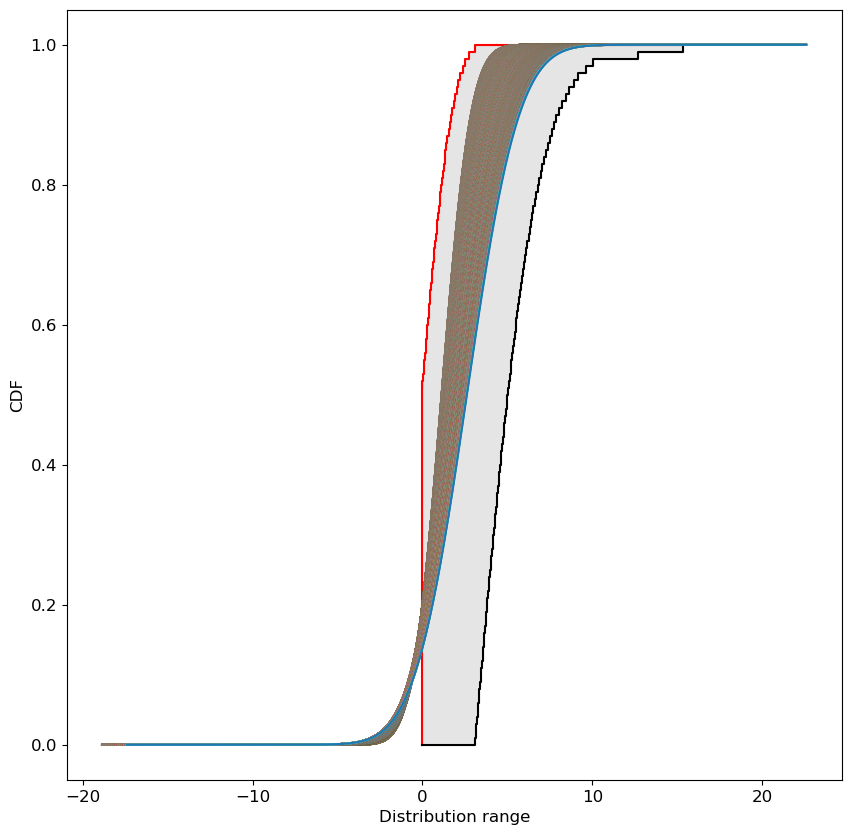

In [18]:
nb_discretization_steps = 100
ProbabilityBoundsAnalysis.setSteps(nb_discretization_steps)
pz = pbox_approximate_nnet(full_net, x, true)
ProbabilityBoundsAnalysis.plot(pz[2])

mean_arr = [0:0.01:1;]

for i in 1:length(mean_arr)
    for j in i:length(mean_arr)
        mean_input = [mean_arr[i], mean_arr[j]]
        cov_input = [1.0 0; 0 1.0]
        mean_output, cov_output = propagate_network(mean_input, cov_input, full_net)
        normal_dist = Normal(mean_output[2], cov_output[2,2])
        supp = range(mean_output[2] - 20, mean_output[2] + 20, length=1000)
        cdf_values = cdf.(normal_dist, supp)
        plot(supp, cdf_values)
    end
end
PyPlot.savefig("MomentPropagationsnd.png")


We see that the propagated Gaussians are outside of the output p-boxes, even in a simple network like our toy example, therefore we deem this approach unsuitable for real experiments.

# Sampling approach

More thorough: we pick one distribution and another and we sample from the two.

In [ ]:
aux = []

#samples
for d in arr
    smp = Base.rand(d,1000)
    push!(aux, smp)
end

#propagate
res = []
for i in 1:length(aux)
    for j in i:length(aux)
        out = []
        for k in 1:length(aux[i])
            out1 = compute_output(full_net, [aux[i][k],aux[j][k]])
            push!(out, out1)
        push!(res, out)
        end
    end
end

#this is super slow for some reason
fst_prop = [[res[i][j][1] for j in 1:length(res[1])] for i in 1:length(res)]
snd_prop = [[res[i][j][2] for j in 1:length(res[1])] for i in 1:length(res)]

In [ ]:
nb_discretization_steps = 100
ProbabilityBoundsAnalysis.setSteps(nb_discretization_steps)
pz = pbox_approximate_nnet(full_net, x, true)

ProbabilityBoundsAnalysis.plot(pz[1])
for ind in 1:length(fst_prop)
    sorted_data, cdf = empirical_cdf(fst_prop[ind])
    plot(sorted_data, cdf, linestyle="-", label="Empirical CDF")
end
PyPlot.savefig("SamplingAppr2fst.png")

In [ ]:
nb_discretization_steps = 100
ProbabilityBoundsAnalysis.setSteps(nb_discretization_steps)
pz = pbox_approximate_nnet(full_net, x, true)
ProbabilityBoundsAnalysis.plot(pz[2])
for ind in 1:length(snd_prop)
    sorted_data, cdf = empirical_cdf(snd_prop[ind])
    plot(sorted_data, cdf, linestyle="-", label="Empirical CDF")
end
PyPlot.savefig("SamplingAppr2snd.png")